In [4]:
from fashion_mnist_master.fashion_mnist_master.utils import mnist_reader
import numpy as np

X_train, y_train = mnist_reader.load_mnist("fashion_mnist_master/fashion_mnist_master/data/fashion", kind='train')
X_test, y_test = mnist_reader.load_mnist("fashion_mnist_master/fashion_mnist_master/data/fashion", kind='t10k')

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 0) Data preparation helpers
# ----------------------------

def prepare_data(X_train, X_test, val_fraction=0.1, normalize=True, seed=123):
    """
    Split train into train/validation, optionally normalize to [0,1],
    and return transposed matrices with shape (features, samples).
    """
    rng = np.random.RandomState(seed)
    N = X_train.shape[0]
    indices = rng.permutation(N)
    n_val = int(N * val_fraction)
    val_idx = indices[:n_val]
    train_idx = indices[n_val:]
    
    X_tr = X_train[train_idx].astype(np.float32)
    X_val = X_train[val_idx].astype(np.float32)
    X_te = X_test.astype(np.float32)
    
    if normalize:
        X_tr = X_tr / 255.0
        X_val = X_val / 255.0
        X_te = X_te / 255.0
    
    # Transpose to shape (features, samples) for our matmul conventions
    return X_tr.T, X_val.T, X_te.T

# ----------------------------
# 1) Initialization
# ----------------------------

def initialize_weights(input_dim, hidden_dim, scale=0.01, seed=None):
    """
    Create W1, b1, W2, b2
    Shapes:
      W1: (hidden_dim, input_dim)
      b1: (hidden_dim, 1)
      W2: (input_dim, hidden_dim)
      b2: (input_dim, 1)
    scale: std multiplier for random normal initialization.
    """
    rng = np.random.RandomState(seed)
    W1 = rng.randn(hidden_dim, input_dim) * scale
    b1 = np.zeros((hidden_dim, 1), dtype=np.float32)
    W2 = rng.randn(input_dim, hidden_dim) * scale
    b2 = np.zeros((input_dim, 1), dtype=np.float32)
    return W1, b1, W2, b2

# ----------------------------
# 2) Activations
# ----------------------------

def sigmoid(z):
    """Sigmoid elementwise. Input shape arbitrary; returns same shape."""
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_derivative_from_activation(s):
    """
    Given s = sigmoid(z), return s * (1-s).
    Using the activation value is numerically more stable than recomputing sigmoid(z).
    """
    return s * (1.0 - s)

# ----------------------------
# 3) Forward pass (single batch)
# ----------------------------

def forward_pass(X_batch, W1, b1, W2, b2):
    """
    Forward for a batch X_batch with shape (input_dim, batch_size).
    Returns:
      y_hat: (input_dim, batch_size)
      cache: tuple of intermediate values for backprop: (X_batch, z1, h, z2, y_hat)
    Steps:
      z1 = W1 @ X + b1      # (hidden_dim, batch)
      h  = sigmoid(z1)      # hidden activations
      z2 = W2 @ h + b2      # (input_dim, batch)
      y_hat = sigmoid(z2)   # reconstruction
    """
    z1 = W1 @ X_batch + b1   # uses broadcasting of b1 along batch dim
    h = sigmoid(z1)
    z2 = W2 @ h + b2
    y_hat = sigmoid(z2)
    cache = (X_batch, z1, h, z2, y_hat)
    return y_hat, cache

# ----------------------------
# 4) Loss (MSE) and PSNR
# ----------------------------

def mse_loss(X, Y):
    """
    Mean squared error per sample averaged over features.
    X and Y shapes: (input_dim, batch_size)
    Returns scalar (mean over all elements).
    """
    diff = X - Y
    return np.mean(diff * diff)

def psnr_from_mse(mse, data_max=1.0):
    """
    PSNR in dB given MSE. Data assumed in [0, data_max].
    PSNR = 10 * log10(MAX^2 / MSE)
    If mse == 0 -> return large number.
    """
    if mse <= 0:
        return 100.0
    return 10.0 * np.log10((data_max ** 2) / mse)

# ----------------------------
# 5) Backprop (batch)
# ----------------------------

def backward_pass(cache, W2):
    """
    Backprop for a batch using cache returned by forward_pass.
    cache = (X, z1, h, z2, y_hat)
    Shapes:
      X      : (input_dim, batch)
      z1     : (hidden_dim, batch)
      h      : (hidden_dim, batch)
      z2     : (input_dim, batch)
      y_hat  : (input_dim, batch)
    Returns gradients with the same shapes as parameters:
      dW1: (hidden_dim, input_dim)
      db1: (hidden_dim, 1)
      dW2: (input_dim, hidden_dim)
      db2: (input_dim, 1)
    Derivation (vectorized over batch):
      dL/dy_hat = 2*(y_hat - X) / (input_dim * batch_size)   # mean over features and samples
      dL/dz2 = dL/dy_hat * sigmoid'(z2)
      dW2 = dL/dz2 @ h.T
      db2 = sum over batch of dL/dz2 (keepdims)
      dL/dh = W2.T @ dL/dz2
      dL/dz1 = dL/dh * sigmoid'(z1)
      dW1 = dL/dz1 @ X.T
      db1 = sum over batch of dL/dz1
    Note: we keep the same averaging used in mse_loss by dividing by total number of elements.
    """
    X, z1, h, z2, y_hat = cache
    input_dim, batch_size = X.shape
    # mean factor: we matched mse_loss which is mean over all elements
    denom = input_dim * batch_size
    dL_dy = 2.0 * (y_hat - X) / denom                    # (input_dim, batch)
    dsig_z2 = sigmoid_derivative_from_activation(y_hat) # (input_dim, batch)
    dL_dz2 = dL_dy * dsig_z2                            # elementwise

    dW2 = dL_dz2 @ h.T                                  # (input_dim, hidden_dim)
    db2 = np.sum(dL_dz2, axis=1, keepdims=True)         # (input_dim, 1)

    dL_dh = W2.T @ dL_dz2                               # (hidden_dim, batch)
    dsig_z1 = sigmoid_derivative_from_activation(h)    # (hidden_dim, batch)
    dL_dz1 = dL_dh * dsig_z1

    dW1 = dL_dz1 @ X.T                                  # (hidden_dim, input_dim)
    db1 = np.sum(dL_dz1, axis=1, keepdims=True)         # (hidden_dim, 1)

    return dW1, db1, dW2, db2

# ----------------------------
# 6) Parameter update
# ----------------------------

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    """
    Simple gradient descent parameter update.
    """
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2
    return W1, b1, W2, b2

# ----------------------------
# 7) Train one epoch (vectorized over batches)
# ----------------------------

def train_epoch(X, W1, b1, W2, b2, lr, batch_size=32):
    """
    Shuffle training set, iterate batches, do forward/backprop/update.
    X: (input_dim, n_samples)
    Returns:
      avg_loss: mean MSE over all training samples this epoch,
      updated parameters (W1,b1,W2,b2)
    Notes:
      This inner loop performs per-batch vectorized gradient computation.
      For numerical stability keep reasonable batch_size (e.g. 32).
    """
    n_samples = X.shape[1]
    perm = np.random.permutation(n_samples)
    total_loss = 0.0
    count = 0

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = perm[start:end]
        X_batch = X[:, batch_idx]               # (input_dim, b)
        y_hat, cache = forward_pass(X_batch, W1, b1, W2, b2)
        loss = mse_loss(X_batch, y_hat)
        dW1, db1, dW2, db2 = backward_pass(cache, W2)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)

        total_loss += loss * (end - start)
        count += (end - start)

    avg_loss = total_loss / count
    return avg_loss, W1, b1, W2, b2

# ----------------------------
# 8) Full training (many epochs) + validation
# ----------------------------

def train_autoencoder(X_train, X_val, input_dim, hidden_dim,
                      epochs=50, lr=0.01, batch_size=32, seed=None, verbose=True):
    """
    High-level training function that runs epochs and returns:
      history = {'train_loss':[], 'val_loss':[], 'val_psnr':[]}
      final params: W1,b1,W2,b2
    """
    W1, b1, W2, b2 = initialize_weights(input_dim, hidden_dim, seed=seed)
    history = {'train_loss': [], 'val_loss': [], 'val_psnr': []}

    for ep in range(1, epochs + 1):
        train_loss, W1, b1, W2, b2 = train_epoch(X_train, W1, b1, W2, b2, lr, batch_size)
        # validation forward (no grads)
        y_val_hat, _ = forward_pass(X_val, W1, b1, W2, b2)
        val_loss = mse_loss(X_val, y_val_hat)
        val_psnr = psnr_from_mse(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_psnr'].append(val_psnr)

        if verbose:
            print(f"Epoch {ep}/{epochs}  Train MSE={train_loss:.6f}  Val MSE={val_loss:.6f}  Val PSNR={val_psnr:.2f} dB")

    return (W1, b1, W2, b2), history

# ----------------------------
# 9) Reconstruction and visualization
# ----------------------------

def reconstruct_samples(X, W1, b1, W2, b2, indices=None, n_show=5):
    """
    Reconstruct selected samples and return original and reconstructed arrays.
    X shape: (input_dim, n_samples)
    indices: list of sample indices to show; if None, choose first n_show.
    Returns:
      originals: (n_show, 28, 28)
      reconstructions: (n_show, 28, 28)
    """
    if indices is None:
        indices = list(range(n_show))
    originals = []
    reconstructions = []
    for idx in indices[:n_show]:
        x = X[:, idx:idx+1]                 # (input_dim,1)
        y_hat, _ = forward_pass(x, W1, b1, W2, b2)
        orig_img = (x.reshape(28,28) * 255.0).astype(np.uint8)
        rec_img = (y_hat.reshape(28,28) * 255.0).clip(0,255).astype(np.uint8)
        originals.append(orig_img)
        reconstructions.append(rec_img)
    return originals, reconstructions

def show_image_pairs(originals, reconstructions, titles=None):
    n = len(originals)
    plt.figure(figsize=(6, 2 * n))
    for i in range(n):
        plt.subplot(n, 2, 2*i+1)
        plt.imshow(originals[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')
        plt.subplot(n, 2, 2*i+2)
        plt.imshow(reconstructions[i], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ----------------------------
# 10) Example run helper
# ----------------------------

def run_example(X_train_raw, X_test_raw, hidden_dim=64, epochs=30, lr=0.01, batch_size=64):
    # prepare and split
    X_tr, X_val, X_te = prepare_data(X_train_raw, X_test_raw, val_fraction=0.1, normalize=True)
    input_dim = X_tr.shape[0]

    # train
    (W1,b1,W2,b2), history = train_autoencoder(X_tr, X_val, input_dim, hidden_dim,
                                              epochs=epochs, lr=lr, batch_size=batch_size, seed=42)

    # plot losses
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='train MSE')
    plt.plot(history['val_loss'], label='val MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history['val_psnr'], label='val PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.show()

    # show reconstructions (first 5 from validation)
    origs, recs = reconstruct_samples(X_val, W1, b1, W2, b2, indices=list(range(5)), n_show=5)
    show_image_pairs(origs, recs)

    # compute final test PSNR
    y_te_hat, _ = forward_pass(X_te, W1, b1, W2, b2)
    test_mse = mse_loss(X_te, y_te_hat)
    test_psnr = psnr_from_mse(test_mse)
    print("Final Test MSE:", test_mse, "Test PSNR (dB):", test_psnr)

    return (W1,b1,W2,b2), history


Epoch 1/100  Train MSE=0.168277  Val MSE=0.166037  Val PSNR=7.80 dB
Epoch 2/100  Train MSE=0.164555  Val MSE=0.162339  Val PSNR=7.90 dB
Epoch 3/100  Train MSE=0.160825  Val MSE=0.158589  Val PSNR=8.00 dB
Epoch 4/100  Train MSE=0.157008  Val MSE=0.154725  Val PSNR=8.10 dB
Epoch 5/100  Train MSE=0.153058  Val MSE=0.150720  Val PSNR=8.22 dB
Epoch 6/100  Train MSE=0.148963  Val MSE=0.146581  Val PSNR=8.34 dB
Epoch 7/100  Train MSE=0.144753  Val MSE=0.142355  Val PSNR=8.47 dB
Epoch 8/100  Train MSE=0.140490  Val MSE=0.138117  Val PSNR=8.60 dB
Epoch 9/100  Train MSE=0.136258  Val MSE=0.133958  Val PSNR=8.73 dB
Epoch 10/100  Train MSE=0.132147  Val MSE=0.129962  Val PSNR=8.86 dB
Epoch 11/100  Train MSE=0.128236  Val MSE=0.126198  Val PSNR=8.99 dB
Epoch 12/100  Train MSE=0.124584  Val MSE=0.122714  Val PSNR=9.11 dB
Epoch 13/100  Train MSE=0.121225  Val MSE=0.119530  Val PSNR=9.23 dB
Epoch 14/100  Train MSE=0.118171  Val MSE=0.116651  Val PSNR=9.33 dB
Epoch 15/100  Train MSE=0.115419  Val MSE=0

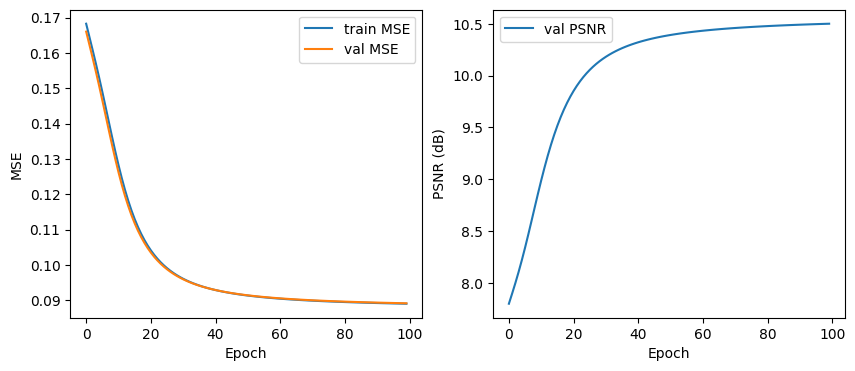

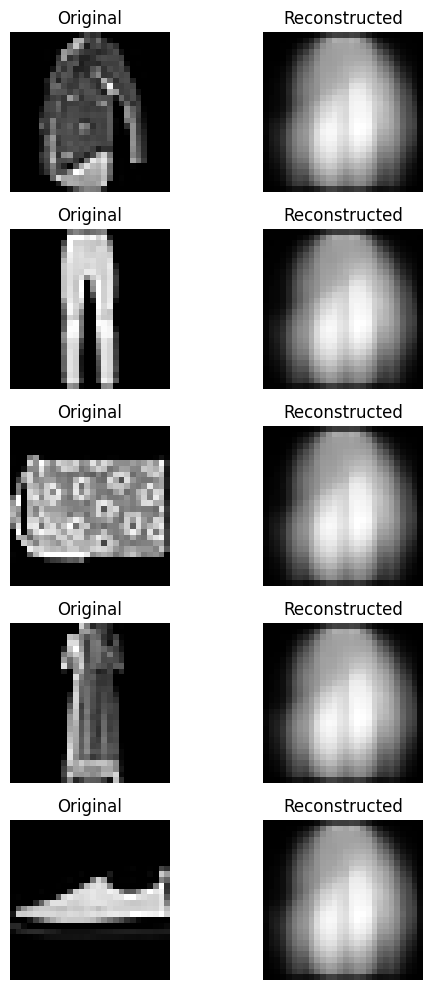

Final Test MSE: 0.08859313688412156 Test PSNR (dB): 10.525999206502233


In [7]:
# Execute Autoencoder
(W1_ae, b1_ae, W2_ae, b2_ae), history = run_example(X_train, X_test, hidden_dim=64, epochs=100, lr=0.01, batch_size=64)

In [8]:
def one_hot_encode(y, num_classes):
    """
    تبدیل بردار لیبل y (شکل (N,)) به ماتریس One-Hot.
    شکل خروجی: (num_classes, N) که N تعداد نمونه ها است.
    """
    # ایجاد یک ماتریس هویت (identity matrix) به ابعاد (num_classes, num_classes)
    # سپس با استفاده از مقادیر y (لیبل ها) ردیف های متناظر را انتخاب می کنیم.
    # نتیجه دارای شکل (N, num_classes) خواهد بود.
    # در نهایت، آن را ترانهاده (Transpose) می کنیم تا به شکل مورد نیاز (num_classes, N) برسد.
    Y_oh = np.eye(num_classes)[y].T
    return Y_oh

# مثال استفاده (فقط برای نمایش، اجرا نمی شود)
# y_oh_train = one_hot_encode(y_train, 10) # y_oh_train: (10, 54000)

In [9]:
def softmax(Z):
    """
    Computes softmax activation for a matrix Z (scores)
    Z shape: (num_classes, batch_size)
    """
    # 1. Subtract the max value along the feature/class axis (axis=0)
    # This prevents numerical overflow from exp(large number)
    Z_stable = Z - np.max(Z, axis=0, keepdims=True)
    
    # 2. Compute exponent
    exp_Z = np.exp(Z_stable)
    
    # 3. Normalize by the sum of exponents
    S = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    return S

In [10]:
def cross_entropy_loss(Y_oh, Y_hat):
    """
    Computes the cross-entropy loss between true labels (Y_oh) and predictions (Y_hat).
    Y_oh, Y_hat shapes: (num_classes, batch_size)
    """
    m = Y_oh.shape[1]
    # Add a small epsilon to Y_hat to prevent log(0)
    epsilon = 1e-12 
    Y_hat = np.clip(Y_hat, epsilon, 1. - epsilon)
    
    # J = - (1/m) * sum(Y * log(Y_hat))
    # Sum over all classes (axis=0) and then mean over all samples
    loss = -np.sum(Y_oh * np.log(Y_hat)) / m
    return loss

In [11]:
def forward_pass_classifier(H_batch, W_cls, b_cls):
    """
    Forward pass for a simple classifier (H -> Output) using Softmax.
    H_batch shape: (hidden_dim=64, batch_size)
    W_cls shape: (num_classes=10, hidden_dim=64)
    b_cls shape: (num_classes=10, 1)
    """
    # z = W @ H + b
    Z = W_cls @ H_batch + b_cls  # (10, batch_size)
    # y_hat = softmax(z)
    Y_hat = softmax(Z)
    cache = (H_batch, Z, Y_hat)
    return Y_hat, cache

In [12]:
def backward_pass_classifier(cache, Y_oh):
    """
    Backprop for classifier using Cross-Entropy Loss.
    cache = (H_batch, Z, Y_hat)
    Y_oh shape: (num_classes, batch_size)
    """
    H_batch, Z, Y_hat = cache
    num_classes, batch_size = Y_oh.shape
    
    # dL/dZ = Y_hat - Y_oh (This is the highly simplified derivative for Softmax + Cross-Entropy)
    dL_dZ = Y_hat - Y_oh # (10, batch_size)
    
    # dW = dL/dZ @ H.T
    dW_cls = dL_dZ @ H_batch.T / batch_size # Mean over batch size
    
    # db = sum(dL/dZ)
    db_cls = np.sum(dL_dZ, axis=1, keepdims=True) / batch_size

    # Note: We don't need dL/dH because we only update the classifier's weights.
    
    return dW_cls, db_cls

In [13]:
def train_classifier(X_enc, Y_oh, epochs=100, lr=0.01, batch_size=64, seed=42):
    """
    Trains the classifier using extracted features (X_enc) and one-hot labels (Y_oh).
    """
    input_dim = X_enc.shape[0] # Should be 64
    num_classes = Y_oh.shape[0] # Should be 10
    n_samples = X_enc.shape[1]
    
    # Initialize classifier weights W_cls (10, 64) and b_cls (10, 1)
    rng = np.random.RandomState(seed)
    W_cls = rng.randn(num_classes, input_dim) * np.sqrt(2 / input_dim) # He Initialization for classifier
    b_cls = np.zeros((num_classes, 1), dtype=np.float32)
    
    history = {'train_loss': [], 'accuracy': []}

    for ep in range(1, epochs + 1):
        perm = np.random.permutation(n_samples)
        total_loss = 0.0
        
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_idx = perm[start:end]
            H_batch = X_enc[:, batch_idx] 
            Y_oh_batch = Y_oh[:, batch_idx]
            
            # Forward
            Y_hat, cache = forward_pass_classifier(H_batch, W_cls, b_cls)
            loss = cross_entropy_loss(Y_oh_batch, Y_hat)
            
            # Backward
            dW_cls, db_cls = backward_pass_classifier(cache, Y_oh_batch)
            
            # Update (Simple GD)
            W_cls = W_cls - lr * dW_cls
            b_cls = b_cls - lr * db_cls
            
            total_loss += loss * (end - start)
        
        avg_loss = total_loss / n_samples
        history['train_loss'].append(avg_loss)

        # Calculate Accuracy on Training Set (for reporting only)
        Y_hat_full, _ = forward_pass_classifier(X_enc, W_cls, b_cls)
        predictions = np.argmax(Y_hat_full, axis=0)
        true_labels = np.argmax(Y_oh, axis=0)
        accuracy = np.mean(predictions == true_labels) * 100
        history['accuracy'].append(accuracy)
        
        # print(f"Epoch {ep}/{epochs}  Train CE Loss={avg_loss:.4f}  Train Accuracy={accuracy:.2f}%")

    return W_cls, b_cls, history

def calculate_accuracy(X_enc_test, Y_test_raw, W_cls, b_cls):
    """Calculates final test accuracy."""
    Y_hat_test, _ = forward_pass_classifier(X_enc_test, W_cls, b_cls)
    predictions = np.argmax(Y_hat_test, axis=0) # Index of max probability is the prediction
    accuracy = np.mean(predictions == Y_test_raw) * 100
    return accuracy

In [16]:
def prepare_data(X_train, X_test, y_train, y_test, val_fraction=0.1, normalize=True, seed=123):
    """
    Split train into train/validation, optionally normalize to [0,1],
    and return transposed matrices with shape (features, samples)   ***Labels (y) are now also split and returned.***
    """
    rng = np.random.RandomState(seed)
    N = X_train.shape[0]
    indices = rng.permutation(N)
    n_val = int(N * val_fraction)
    val_idx = indices[:n_val]
    train_idx = indices[n_val:]

    # Shuffle and split features
    X_tr = X_train[train_idx].astype(np.float32)
    X_val = X_train[val_idx].astype(np.float32)
    X_te = X_test.astype(np.float32)

    # Shuffle and split labels (Crucial Step)
    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]
    
    if normalize:
         ظX_tr = X_tr / 255.0
         X_val = X_val / 255.0
         X_te = X_te / 255.0
    
    # Transpose X matrices to shape (features, samples)
    return X_tr.T, X_val.T, X_te.T, y_tr, y_val, y_test

# --- مرحله فراخوانی داده‌ها با تابع اصلاح شده ---
X_tr, X_val, X_te, y_tr, y_val, y_te = prepare_data(X_train, X_test, y_train, y_test, val_fraction=0.1, normalize=True)

# 1. آماده سازی لیبل ها
# حالا y_tr فقط شامل 54000 لیبل آموزشی است که با X_tr مطابقت دارد.
y_train_oh = one_hot_encode(y_tr, 10) 
y_val_oh = one_hot_encode(y_val, 10) 
y_test_oh = one_hot_encode(y_te, 10) # y_test_oh برای consistency

# 2. استخراج ویژگی ها (X_enc_train از X_tr و X_enc_test از X_te ساخته شده است)
def extract_features(X_data, W1, b1):
    Z1 = W1 @ X_data + b1
    H = sigmoid(Z1) 
    return H

# فرض بر این است که W1_ae و b1_ae از فاز ۱ در دسترس است
X_enc_train = extract_features(X_tr, W1_ae, b1_ae) # (64, 54000)
X_enc_test = extract_features(X_te, W1_ae, b1_ae)  # (64, 10000)

# 3. آموزش طبقه‌بند (فراخوانی صحیح)
print("\n--- Training Classifier (64 -> 10) ---")
# حالا y_train_oh به درستی 54000 نمونه دارد و با X_enc_train مطابقت دارد.
W_cls, b_cls, cls_history = train_classifier(X_enc_train, y_train_oh, epochs=100, lr=0.05, batch_size=128)

# 4. محاسبه دقت نهایی
# y_test را به جای y_test_oh به تابع calculate_accuracy پاس می دهیم
final_test_accuracy = calculate_accuracy(X_enc_test, y_test, W_cls, b_cls)

print(f"\nFinal Classification Test Accuracy (using AE features): {final_test_accuracy:.2f}%")


--- Training Classifier (64 -> 10) ---

Final Classification Test Accuracy (using AE features): 10.00%


In [17]:
def relu(Z):
    """ReLU elementwise. Returns max(0, Z)."""
    return np.maximum(0, Z)

def relu_derivative_from_activation(H):
    """
    Given H = relu(Z), returns the derivative.
    The derivative is 1 for positive elements and 0 otherwise.
    """
    return (H > 0).astype(np.float32)

In [18]:
# --- فرض بر این است که (W1_ae, b1_ae) از فاز ۱ در دسترس است ---

# 1. آماده سازی داده ها (با تابع اصلاح شده در دور قبلی)
X_tr, X_val, X_te, y_tr, y_val, y_te = prepare_data(X_train, X_test, y_train, y_test, val_fraction=0.1, normalize=True)
y_train_oh = one_hot_encode(y_tr, 10) 
y_test = y_te # لیبل های تست برای محاسبه دقت

# 2. تابع استخراج ویژگی (با فرض Sigmoid به دلیل ساختار AE)
def extract_features(X_data, W1, b1):
    """Extracts features (h) from the trained encoder using Sigmoid."""
    Z1 = W1 @ X_data + b1
    H = sigmoid(Z1) 
    return H

# 3. استخراج ویژگی ها 
# فرض می‌کنیم W1_ae و b1_ae از فاز ۱ (Autoencoder) موجود باشند
X_enc_train = extract_features(X_tr, W1_ae, b1_ae) 
X_enc_test = extract_features(X_te, W1_ae, b1_ae)  

# 4. آموزش طبقه‌بند با نرخ یادگیری بالا (برای غلبه بر اشباع Sigmoid)
print("\n--- Training Classifier (64 -> 10) with Higher LR ---")
W_cls, b_cls, cls_history = train_classifier(X_enc_train, y_train_oh, epochs=100, lr=0.5, batch_size=128)

# 5. محاسبه دقت نهایی
final_test_accuracy = calculate_accuracy(X_enc_test, y_test, W_cls, b_cls)

print(f"\nFinal Classification Test Accuracy (using AE features) with LR=0.5: {final_test_accuracy:.2f}%")


--- Training Classifier (64 -> 10) with Higher LR ---

Final Classification Test Accuracy (using AE features) with LR=0.5: 10.00%


In [19]:
# تابع استخراج ویژگی اصلاح شده
def extract_features_modified(X_data, W1, b1):
    """
    Extracts the PRE-ACTIVATION (Z1) from the trained encoder.
    This provides features that are NOT saturated by Sigmoid.
    """
    Z1 = W1 @ X_data + b1
    # H = sigmoid(Z1) <--- حذف شد
    return Z1

In [20]:
# --- اجرای نهایی با ویژگی های غیر اشباع شده ---
# 1. داده‌ها قبلاً تقسیم و آماده شده‌اند: X_tr, X_te, y_tr, y_te
# 2. تابع extract_features اصلاح شده است (بازگشت Z1)

# 3. استخراج ویژگی های جدید
# فرض می‌کنیم W1_ae و b1_ae از فاز ۱ (Autoencoder) موجود باشند
X_enc_train = extract_features_modified(X_tr, W1_ae, b1_ae) 
X_enc_test = extract_features_modified(X_te, W1_ae, b1_ae)  

# 4. آموزش طبقه‌بند با نرخ یادگیری مناسب
print("\n--- Training Classifier (64 -> 10) with Z1 Features ---")
# نرخ یادگیری را به یک مقدار متعادل (0.05) برمی‌گردانیم
W_cls, b_cls, cls_history = train_classifier(X_enc_train, y_train_oh, epochs=100, lr=0.05, batch_size=128)

# 5. محاسبه دقت نهایی
final_test_accuracy = calculate_accuracy(X_enc_test, y_test, W_cls, b_cls)

print(f"\nFinal Classification Test Accuracy (using Z1 features) with LR=0.05: {final_test_accuracy:.2f}%")


--- Training Classifier (64 -> 10) with Z1 Features ---

Final Classification Test Accuracy (using Z1 features) with LR=0.05: 62.60%


In [21]:
# 1. محاسبه خروجی Softmax برای مجموعه تست
Y_hat_test, _ = forward_pass_classifier(X_enc_test, W_cls, b_cls)

# 2. استخراج لیبل پیش بینی شده (اندیس با بیشترین احتمال)
predictions = np.argmax(Y_hat_test, axis=0)

# 3. لیبل های واقعی
true_labels = y_test

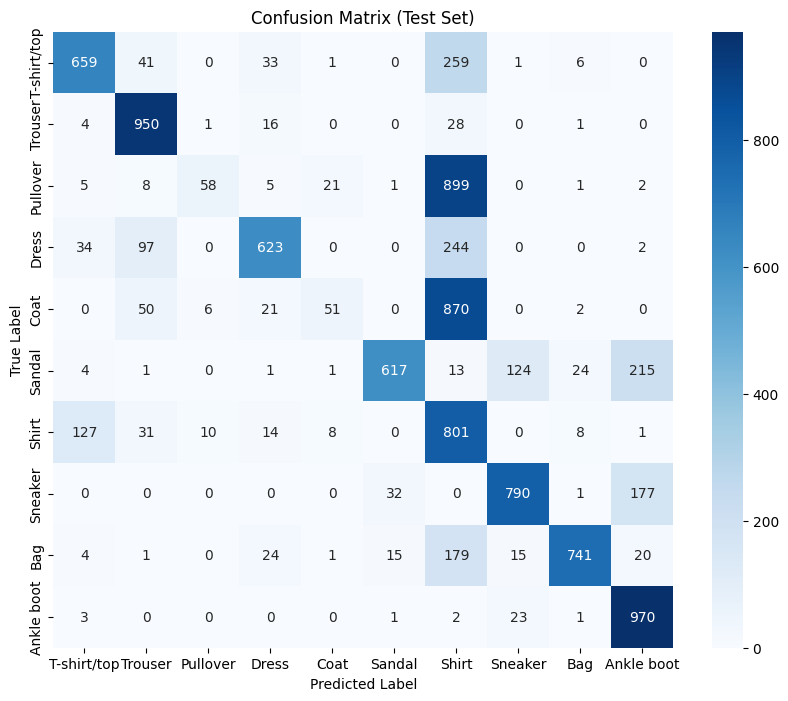

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns # برای نمایش بهتر نمودار
import pandas as pd

# محاسبه ماتریس درهم ریختگی
cm = confusion_matrix(true_labels, predictions)

# نام کلاس ها (برای Fashion-MNIST)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# تبدیل به DataFrame برای نمایش بهتر
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# نمایش به صورت یک نقشه حرارتی (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()